In [1]:
import os

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from tslearn.metrics import dtw
from umap import UMAP
from tqdm import tqdm
import ruptures

from infodynamics import WindowedRollingDistance
from infodynamics.util import calc_vector_histogram

from src.dataset.util import read_jsonl, write_jsonl

/Users/au582299/Repositories/friths/.venv/lib/python3.11/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)
/Users/au582299/Repositories/friths/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def generate_xticks(df):
    # flag indices, where the next element is different
    yr_switches = np.diff(df["year"])
    # add last element
    yr_switches = np.append(0, yr_switches)
    # convert to bool
    yr_switches = np.array(yr_switches, dtype=bool)

    # get index (x-axis) and year variables (x-axis label)
    sig_index = np.array(df.index)
    sig_year = np.array(df["year"])

    # mark changes in year
    xticks_idx = sig_index[yr_switches]
    xticks_label = sig_year[yr_switches]

    return xticks_idx, xticks_label

# data
select only article bodies with embeddings for further analysis

In [3]:
INTERIM_PATH = '../data/interim/'
PROCESSED_PATH = '../data/processed/'

embs = read_jsonl(os.path.join(PROCESSED_PATH, 'publications_merged_concat.ndjson'))
meta = pd.read_csv(os.path.join(PROCESSED_PATH, 'meta_publications_months.csv'), sep=';')
quality = pd.read_csv(os.path.join(PROCESSED_PATH, 'meta_publications_quality.csv'))

In [4]:
# split into publication id & section
embs_df = pd.DataFrame(embs).drop(columns=['pub_date'])
embs_df[['pub_id', 'section']] = embs_df['id'].str.split('_', expand=True) 
embs_df.head()

,id,text,embeddings,warning,pub_id,section
0,p1_a,,[],empty,p1,a
1,p1_b,\nfor other things and stumbled across psychol...,"[-0.010761050507426262, 0.02184978313744068, 0...",ok :),p1,b
2,p2_a,"This article may be used for research, teachin...","[-0.009430318139493465, 0.0022036083973944187,...",ok :),p2,a
3,p2_b,"\nIn their classic work, Heider and Simmel (19...","[-0.030965760350227356, 0.0006598980980925262,...",ok :),p2,b
4,p3_a,,[],empty,p3,a


In [5]:
# reconstruct yyyy-mm-dd date
dates = []
for i, row in meta.iterrows():
    year_month = f"{int(row['year'])}-{int(row['month'])}-01"
    pub_date = pd.to_datetime(year_month, format='%Y-%m-%d')
    dates.append(pub_date)

meta['date'] = dates
meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 272 entries, 0 to 271
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   pub_id  272 non-null    object        
 1   path    272 non-null    object        
 2   doi     142 non-null    object        
 3   source  272 non-null    object        
 4   year    272 non-null    float64       
 5   month   272 non-null    int64         
 6   date    272 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(1), object(4)
memory usage: 15.0+ KB


In [6]:
# clean up quality
rows_to_include = []
for i, group in quality.groupby('pub_id'):
    # pick the pub_id with high n_characters
    top_row_in_grp = group['n_characters'].idxmax()
    rows_to_include.append(top_row_in_grp)

quality_short = quality.loc[rows_to_include]
quality_short.drop(columns=['Unnamed: 0', 'year', 'date', 'title', 'source'], inplace=True)
quality_short.reset_index(drop=True, inplace=True)

In [7]:
# merge embeddings with metadata
df = embs_df.merge(meta[['pub_id', 'year', 'source', 'date']], on='pub_id', how='left')
df = df.merge(quality_short, on='pub_id', how='left')
# sort by date!
df = df.sort_values('date')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 544 entries, 376 to 128
Data columns (total 86 columns):
 #   Column                                  Non-Null Count  Dtype         
---  ------                                  --------------  -----         
 0   id                                      544 non-null    object        
 1   text                                    544 non-null    object        
 2   embeddings                              544 non-null    object        
 3   warning                                 544 non-null    object        
 4   pub_id                                  544 non-null    object        
 5   section                                 544 non-null    object        
 6   year                                    544 non-null    float64       
 7   source                                  544 non-null    object        
 8   date                                    544 non-null    datetime64[ns]
 9   path                                    544 non-null    o

### checking missing data

In [8]:
df.query('warning == "empty"').groupby('section').size()

section
a    78
dtype: int64

In [9]:
df['warning'] = df['warning'].str.slice(0, 15)
df.groupby('warning').size()

warning
empty     78
ok :)    466
dtype: int64

### analysis subset
no abstracts, full embeddings

In [10]:
# select only full embeddings & article bodies
df_full = (df
               .query('warning == "ok :)"')
               .query('section == "b"')
               )

df_full

,id,text,embeddings,warning,pub_id,section,year,source,date,path,...,duplicate_ngram_chr_fraction_7,duplicate_ngram_chr_fraction_8,duplicate_ngram_chr_fraction_9,duplicate_ngram_chr_fraction_10,top_ngram_chr_fraction_2,top_ngram_chr_fraction_3,top_ngram_chr_fraction_4,oov_ratio,first_order_coherence,second_order_coherence
377,p189_b,INTRODUCTION\nOne of the most important featur...,"[-0.01675822027027607, 0.025037338957190514, 0...",ok :),p189,b,1969.0,parsing,1969-01-01,data/raw/publications_manual_export/UTA public...,...,0.023036,0.018319,0.014480,0.014480,0.004936,0.002742,0.004827,0.021277,0.720727,0.716600
379,p190_b,"\n(1965,\n1966)\n \nhave demonstrated the int...","[-0.0327637754380703, 0.02097960375249386, 0.0...",ok :),p190,b,1969.0,parsing,1969-09-01,data/raw/publications_manual_export/UTA public...,...,0.012318,0.003285,0.001725,0.001725,0.007761,0.003162,0.004106,0.018515,0.701840,0.688619
373,p187_b,\nIt has recently been suggested that the unde...,"[-0.030136963352560997, 0.03472242131829262, 0...",ok :),p187,b,1970.0,parsing,1970-01-01,data/raw/publications_manual_export/UTA public...,...,0.017183,0.017183,0.009446,0.005668,0.011066,0.004858,0.003599,0.023398,0.791399,0.772947
371,p186_b,\nI t could be hypothesized that there are two...,"[-0.03267296031117439, 0.018821272999048233, 0...",ok :),p186,b,1970.0,parsing,1970-06-01,data/raw/publications_manual_export/UTA public...,...,0.023654,0.017196,0.010888,0.003379,0.013967,0.002816,0.005632,0.034496,0.725820,0.696124
375,p188_b,\nThe hypothesis of a deficit in central proce...,"[-0.034630823880434036, 0.028664667159318924, ...",ok :),p188,b,1970.0,parsing,1970-08-01,data/raw/publications_manual_export/UTA public...,...,0.029186,0.020742,0.014905,0.006687,0.015811,0.005667,0.001785,0.053989,0.768336,0.748973
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,p76_b,\nUta Frith began her science career studying ...,"[-0.021618565544486046, 0.0042715719901025295,...",ok :),p76,b,2020.0,parsing,2020-07-01,data/raw/publications_manual_export/UTA public...,...,0.003399,0.001785,0.000996,0.000000,0.006867,0.002283,0.001202,0.012490,0.724964,0.709370
131,p66_b,"\nGoldman, 2006;\nGopnik, 1993)\n. Autism thu...","[-0.02129972167313099, 0.0030547252390533686, ...",ok :),p66,b,2021.0,parsing,2021-01-01,data/raw/publications_manual_export/UTA public...,...,0.031222,0.025685,0.025685,0.025685,0.005282,0.002172,0.002726,0.048368,0.660822,0.649696
139,p70_b,Introduction\nTheory of Mind is defined as the...,"[-0.030077671632170677, -0.007493732497096062,...",ok :),p70,b,2021.0,parsing,2021-01-01,data/raw/publications_manual_export/UTA public...,...,0.089361,0.061754,0.043415,0.029114,0.004265,0.006824,0.006170,0.043307,0.781824,0.770902
149,p75_b,\nWe are grateful for the careful thought that...,"[-0.02133309282362461, 0.02723802998661995, 0....",ok :),p75,b,2021.0,parsing,2021-02-01,data/raw/publications_manual_export/UTA public...,...,0.000000,0.000000,0.000000,0.000000,0.015061,0.031238,0.000000,0.024416,0.796414,0.819043


### source comparison
check information extraction strategies

/var/folders/9n/_b0__0295cs17prkkfjglwwd87mgrt/T/ipykernel_92280/187866916.py:4: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  all_years_in_range = pd.date_range(start=df_full['year_'].min(), end=df_full['year_'].max(), freq='Y').year


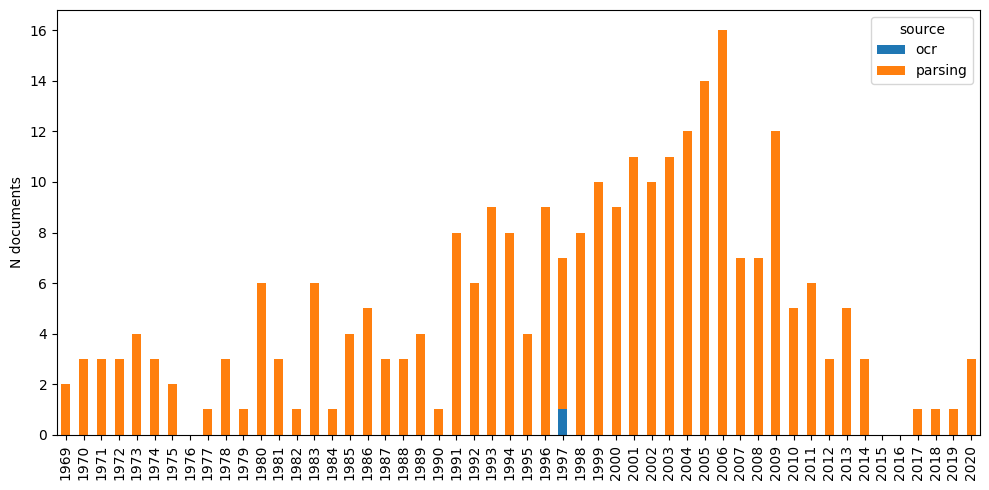

In [11]:
# year: datetime is for counting, year: float is for visualization
df_full['year_'] = pd.to_datetime(df_full['year'], format='%Y')
# generate all years between first and last publication (incl)
all_years_in_range = pd.date_range(start=df_full['year_'].min(), end=df_full['year_'].max(), freq='Y').year

# inject our publication dataset with all years (add years without publications)
proportions = df_full.groupby(['year', 'source']).size().unstack(fill_value=0) #.apply(lambda x: x / x.sum(), axis=1)
proportions = proportions.reindex(all_years_in_range, fill_value=0)

fig, ax = plt.subplots(figsize=(10, 5))
proportions.plot(kind='bar', stacked=True, ax=ax)
ax.set_ylabel('N documents')
plt.tight_layout()
plt.savefig('fig/source_breakdown.png', dpi=300)

### sanity check for missing documents

In [12]:
def get_file_paths(folder_path: str) -> tuple[list, list]:
    """
    """

    pdf_paths = []
    other_paths = []
    for root, directories, files in os.walk(folder_path):
        for filename in files:
            filepath = os.path.join(root, filename)
            if filename.endswith('.pdf'):
                pdf_paths.append(filepath)
            else:
                other_paths.append(filepath)

    return pdf_paths, other_paths

pdf_paths, other_paths = get_file_paths('../data/raw/publications_manual_export/UTA publications/')
pdf_paths = [path[3:] for path in pdf_paths]
len(pdf_paths)

272

In [13]:
# how many docs are not overlapping
len(
    set(pdf_paths) - set(meta['path'].unique().tolist())
)

6

We have two types of documents:
- `parsing`: PDFs with extractable text (n=154). Mostly the newer publications that were "born digitally"
- `ocr`: PDFs where we had to conduct optical character recognition ourselves (n=121).

The difference in text quality between these two types of documents is substantial; We address this by using a robust pre-trained model to acquire the representations, but need a couple more checks.  
We successfully parsed 271 PDF files out of 272.  

# 2D plots

In [14]:
X_2d = UMAP(n_components=2, random_state=42, metric='cosine').fit_transform(df_full['embeddings'].tolist())

/Users/au582299/Repositories/friths/.venv/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


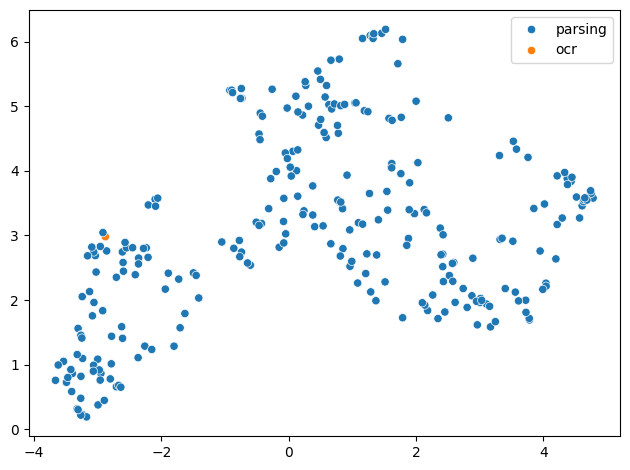

In [15]:
sns.scatterplot(
    x=X_2d[:, 0],
    y=X_2d[:, 1],
    hue=df_full['source'].tolist(),
)

plt.tight_layout()
plt.savefig('fig/embeddings_umap_source.png', dpi=300)

/var/folders/9n/_b0__0295cs17prkkfjglwwd87mgrt/T/ipykernel_92280/2019212768.py:3: UserWarning: The palette list has more values (9) than needed (7), which may not be intended.
  sns.scatterplot(


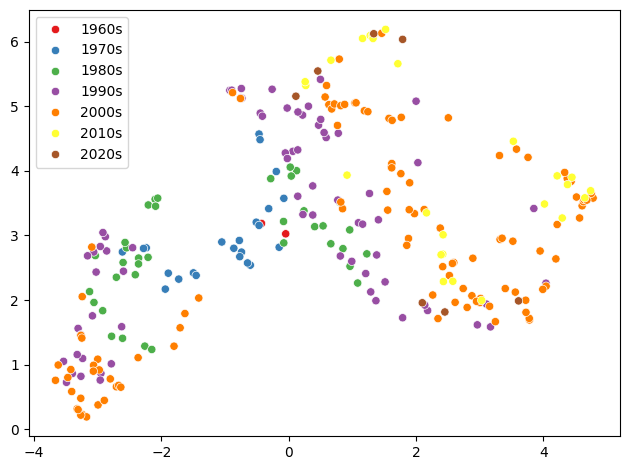

In [16]:
decades = [str(year)[0:3] + '0s' for year in df_full['year'].tolist()]

sns.scatterplot(
    x=X_2d[:, 0],
    y=X_2d[:, 1],
    hue=decades,
    palette=sns.color_palette("Set1")
)

plt.tight_layout()
plt.savefig('fig/embeddings_umap_year.png', dpi=300)

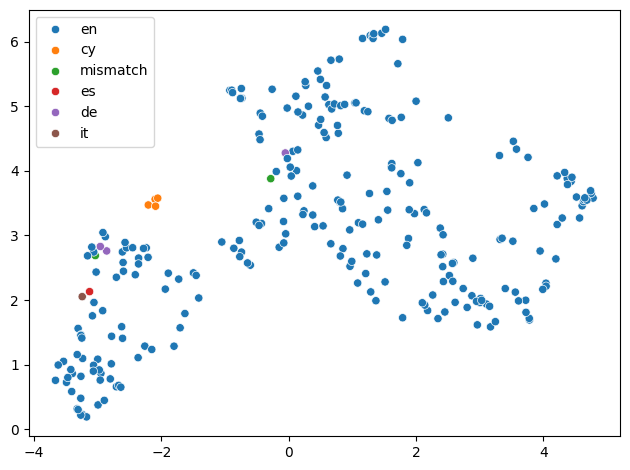

In [17]:
sns.scatterplot(
    x=X_2d[:, 0],
    y=X_2d[:, 1],
    hue=df_full['lang'].tolist(),
)

plt.tight_layout()
plt.savefig('fig/embeddings_umap_lang.png', dpi=300)

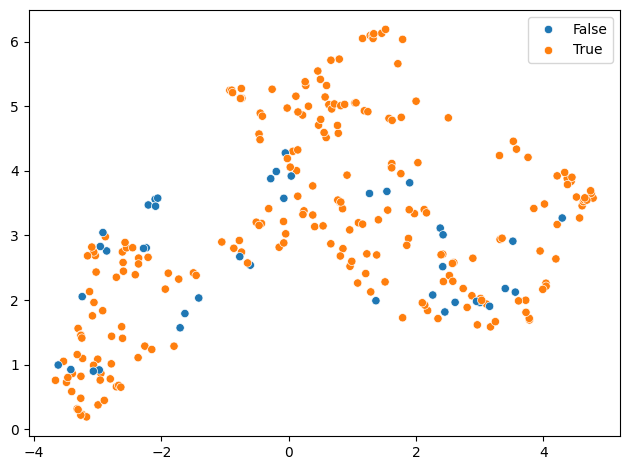

In [18]:
sns.scatterplot(
    x=X_2d[:, 0],
    y=X_2d[:, 1],
    hue=df_full['passed_quality_check'].tolist(),
)

plt.tight_layout()
plt.savefig('fig/embeddings_umap_qualitycheck.png', dpi=300)

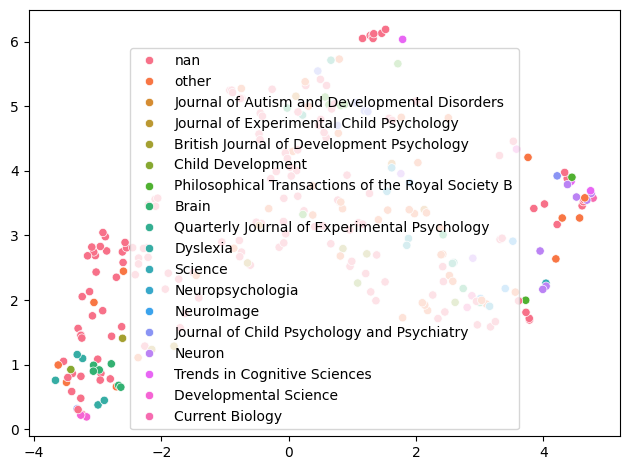

In [20]:
often_published_journals = (df_full
    .groupby('Journal')
    .size()
    .sort_values(ascending=False)
    .reset_index()
    .rename(columns={0:'n'})
    .query('n >= 3')
 )['Journal'].tolist()

journal_mapping = []
for journal in df_full['Journal'].tolist():
    if journal in often_published_journals:
        journal_mapping.append(journal)
    elif isinstance(journal, str):
        journal_mapping.append('other')
    else:
        journal_mapping.append('nan')

sns.scatterplot(
    x=X_2d[:, 0],
    y=X_2d[:, 1],
    hue=journal_mapping,
)

plt.tight_layout()
# plt.savefig('fig/embeddings_umap_journals.png', dpi=300)

# infodynamics


In [22]:
X = df_full['embeddings'].tolist()
X = np.array(X)
X.shape

(272, 1536)

In [23]:
X_prob = [calc_vector_histogram(vect, bins=100) for vect in X]
X_prob = np.array(X_prob)
X_prob.shape

(272, 100)

### window testing
run through a bunch of windows, then calculate dtw between them and pick the one with the lowest avg distance

In [23]:
w_grid = list(range(2, 51))
signals_w = {}

for w in tqdm(w_grid):

    wd_i = WindowedRollingDistance(
        measure='jensenshannon',
        window_size=w,
        estimate_error=True
    )

    signal_i = wd_i.fit_transform(X_prob)
    signals_w.update({w: signal_i})

  0%|          | 0/49 [00:00<?, ?it/s]

100%|██████████| 49/49 [00:01<00:00, 29.93it/s]


In [24]:
cut_zeros = False

distance_matrix = []
for index_left in tqdm(w_grid):
    distance_row = []
    nov_left = signals_w[index_left]['N_hat'].reshape(-1, 1)
    if cut_zeros:
        nov_left = nov_left[index_left:]
    for index_right in w_grid:
        nov_right = signals_w[index_right]['N_hat'].reshape(-1, 1)
        if cut_zeros:
            nov_right = nov_right[index_right:]
        dist = dtw(nov_left, nov_right)
        distance_row.append(dist)
    distance_matrix.append(distance_row)

100%|██████████| 49/49 [00:01<00:00, 34.62it/s]


,window,inertia
22,24,0.465809
19,21,0.468317
20,22,0.470965
21,23,0.471029
23,25,0.472921


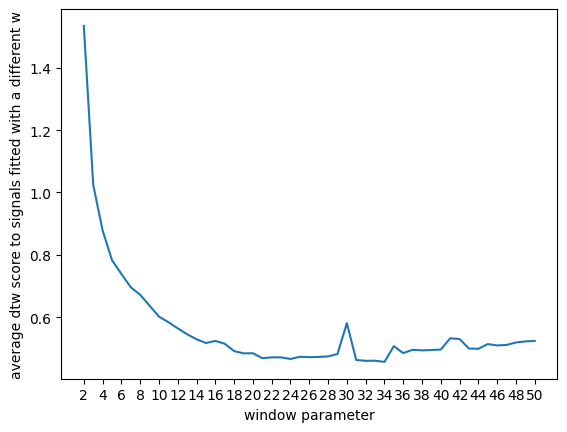

In [25]:
window_intertia = pd.DataFrame({
    'window': list(range(2, 51)),
    'inertia': np.array(distance_matrix).mean(axis=1)
})

plt.plot(
    window_intertia['window'],
    window_intertia['inertia']
)

plt.xticks(range(2, 51, 2))
plt.xlabel('window parameter')
plt.ylabel('average dtw score to signals fitted with a different w')

(window_intertia
    .query('window <= 25')
    .sort_values(by='inertia')
    .head(5)
    )

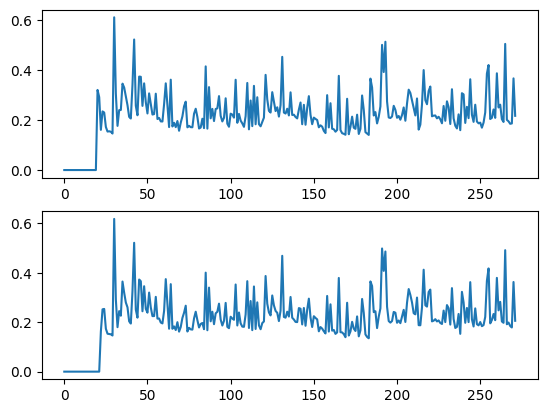

In [26]:
fig, axs = plt.subplots(nrows=2)
axs[0].plot(signals_w[20]['N_hat'])
axs[1].plot(signals_w[22]['N_hat'])

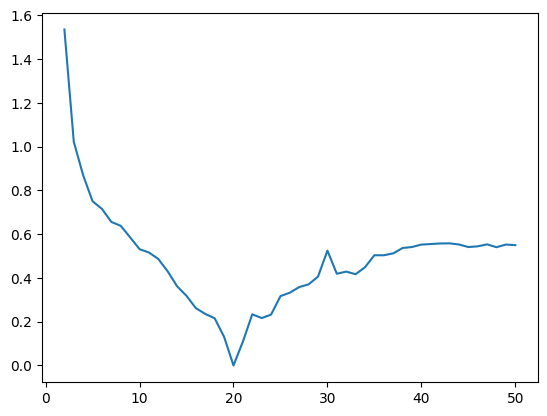

In [27]:
distances_to_main = []
for w in w_grid:
    d_to_main = dtw(signals_w[20]['N_hat'], signals_w[w]['N_hat'])
    distances_to_main.append(d_to_main)

plt.plot(
    w_grid, 
    distances_to_main
)

### window=20

In [24]:
w_main = WindowedRollingDistance(
    measure='jensenshannon',
    window_size=20,
    estimate_error=True
)

signal = w_main.fit_transform(X_prob)

In [25]:
signal_df = pd.DataFrame(signal)
signal_df['pub_id'] = df_full['pub_id'].tolist()
signal_df['date'] = df_full['date'].tolist()
signal_df['year'] = df_full['year'].astype(int).tolist()
signal_df.to_csv('fig/signal_pub_jsd_w20.csv', index=False)

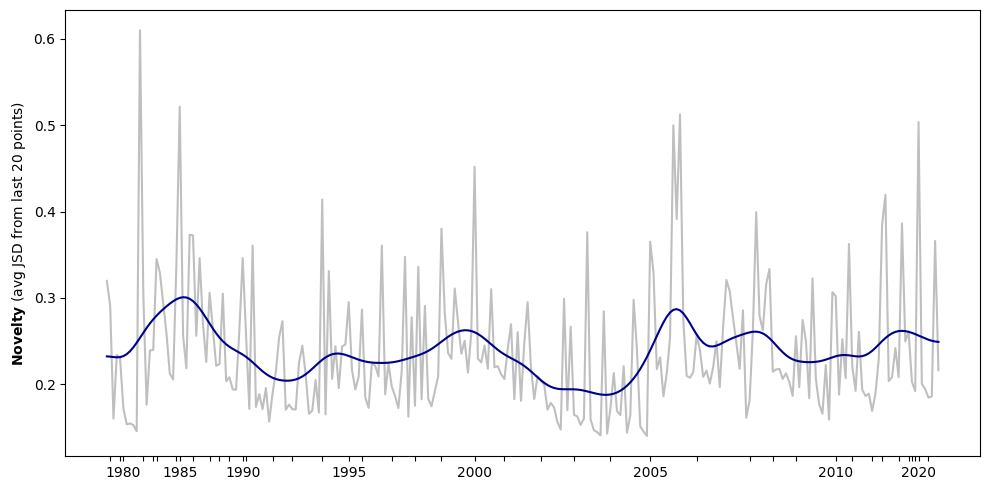

In [27]:
n_df = signal_df.iloc[20:, :]
n_hat = n_df['N_hat'].tolist()

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(n_hat, c='grey', alpha=0.5)
ax.plot(
    gaussian_filter1d(n_hat, sigma=5), c='darkblue'
)

xticks_idx_n, xticks_label_n = generate_xticks(n_df.reset_index())
modified_ticks = ['' if i % 5 != 0 and i != xticks_label_n[0] else i for i in xticks_label_n]

values_to_hide = [1978, 1979]
modified_ticks = ['' if i in values_to_hide else i for i in modified_ticks]

ax.set_xticks(ticks=xticks_idx_n, labels=modified_ticks)
ax.set_ylabel(r'$\bf{Novelty}$ (avg JSD from last 20 points)')

plt.tight_layout()
plt.savefig('fig/novelty_w20_doc2doc.png', dpi=300)

/Users/au582299/Repositories/friths/.venv/lib/python3.11/site-packages/seaborn/categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/Users/au582299/Repositories/friths/.venv/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


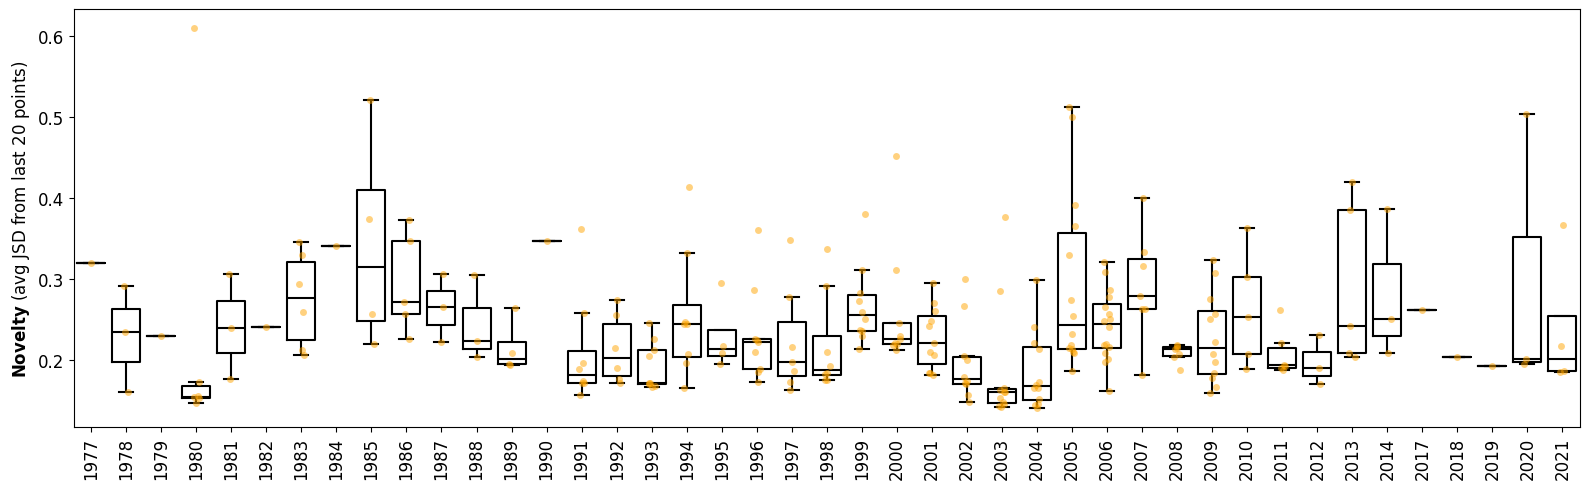

In [28]:
fig, ax = plt.subplots(figsize=(16, 5))
sns.boxplot(x=n_df['year'], y=n_df['N_hat'], ax=ax, showfliers=False, fill=False, color='black')
sns.stripplot(x=n_df['year'], y=n_df['N_hat'], ax=ax, color='orange', alpha=0.5)

ax.tick_params(axis='x', labelrotation=90, labelsize=12)
ax.tick_params(axis='y', labelsize=12)
ax.set_xlabel(None)
ax.set_ylabel(r'$\bf{Novelty}$ (avg JSD from last 20 points)', fontsize=12)

plt.tight_layout()
plt.savefig('fig/novelty_w20_boxplot_yrly_avg.png', dpi=300)

### peaks

In [36]:
peak_thres = 0.4
r_df.query('N_hat > @peak_thres')

,N_hat,N_sd,T_hat,T_sd,R_hat,R_sd,pub_id,date,year
30,0.609895,0.089942,0.631898,0.158115,-0.022003,0.124028,p162,1980-06-01,1980
42,0.521301,0.159404,0.342304,0.134550,0.178997,0.146977,p127,1985-03-01,1985
85,0.413933,0.106714,0.361591,0.149610,0.052342,0.128162,p147,1994-01-01,1994
131,0.452022,0.161332,0.417891,0.129308,0.034131,0.145320,p174,2000-01-01,2000
191,0.499804,0.134773,0.424817,0.173294,0.074987,0.154034,p40,2005-10-01,2005
193,0.512301,0.163543,0.420282,0.137577,0.092020,0.150560,p44,2005-10-01,2005
255,0.419281,0.153517,0.000000,0.000000,0.419281,0.076759,p69,2013-02-01,2013
265,0.503664,0.152637,0.000000,0.000000,0.503664,0.076318,p67,2020-01-01,2020


In [39]:
peak_ids = r_df.query('N_hat > @peak_thres')['pub_id'].tolist()
meta.query('pub_id == @peak_ids').sort_values('year')['path'].tolist()

['data/raw/publications_manual_export/UTA publications/UF papers 1969-2004 copy/1980/Frith, The world of two dimensional space.pdf',
 'data/raw/publications_manual_export/UTA publications/UF papers 1969-2004 copy/1985/Frith, The usefulness of the concept of unexpected reading failure.pdf',
 'data/raw/publications_manual_export/UTA publications/UF papers 1969-2004 copy/1994/Frith, Preface to Handbook of Spelling.pdf',
 'data/raw/publications_manual_export/UTA publications/UF papers 1969-2004 copy/2000/Abell, Happe and Frith, Do triangles play tricks.pdf',
 'data/raw/publications_manual_export/UTA publications/UF papers 2005-2006 copy/SIlani Paulesu VBM.pdf',
 'data/raw/publications_manual_export/UTA publications/UF papers 2005-2006 copy/Silani Dys Proofs.pdf',
 'data/raw/publications_manual_export/UTA publications/UF papers 2014 - 2021 copy/BRITAC_PBA 211_UFrith Spin UFEdited.pdf',
 'data/raw/publications_manual_export/UTA publications/UF papers 2014 - 2021 copy/Fast Lane to Slow Scienc

In [40]:
r_df.query('N_hat > @peak_thres')

,N_hat,N_sd,T_hat,T_sd,R_hat,R_sd,pub_id,date,year
30,0.609895,0.089942,0.631898,0.158115,-0.022003,0.124028,p162,1980-06-01,1980
42,0.521301,0.159404,0.342304,0.134550,0.178997,0.146977,p127,1985-03-01,1985
85,0.413933,0.106714,0.361591,0.149610,0.052342,0.128162,p147,1994-01-01,1994
131,0.452022,0.161332,0.417891,0.129308,0.034131,0.145320,p174,2000-01-01,2000
191,0.499804,0.134773,0.424817,0.173294,0.074987,0.154034,p40,2005-10-01,2005
193,0.512301,0.163543,0.420282,0.137577,0.092020,0.150560,p44,2005-10-01,2005
255,0.419281,0.153517,0.000000,0.000000,0.419281,0.076759,p69,2013-02-01,2013
265,0.503664,0.152637,0.000000,0.000000,0.503664,0.076318,p67,2020-01-01,2020


In [52]:
r_df.query('pub_id == "p45"')

,N_hat,N_sd,T_hat,T_sd,R_hat,R_sd,pub_id,date,year
189,0.212595,0.107338,0.274701,0.164974,-0.062106,0.136156,p45,2005-10-01,2005


In [46]:
r_df.iloc[165:175, :]

,N_hat,N_sd,T_hat,T_sd,R_hat,R_sd,pub_id,date,year
185,0.329753,0.134199,0.295425,0.171709,0.034328,0.152954,p21,2005-01-01,2005
186,0.217752,0.102215,0.213337,0.155476,0.004415,0.128846,p22,2005-01-01,2005
187,0.231371,0.116337,0.252943,0.159632,-0.021571,0.137984,p24,2005-06-01,2005
188,0.186144,0.106679,0.218234,0.122338,-0.032090,0.114508,p43,2005-07-01,2005
189,0.212595,0.107338,0.274701,0.164974,-0.062106,0.136156,p45,2005-10-01,2005
190,0.254112,0.135311,0.345900,0.167197,-0.091788,0.151254,p39,2005-10-01,2005
191,0.499804,0.134773,0.424817,0.173294,0.074987,0.154034,p40,2005-10-01,2005
192,0.391408,0.158746,0.462965,0.140098,-0.071557,0.149422,p48,2005-10-01,2005
193,0.512301,0.163543,0.420282,0.137577,0.092020,0.150560,p44,2005-10-01,2005
194,0.273618,0.134192,0.191642,0.076670,0.081976,0.105431,p33,2005-11-01,2005


In [53]:
meta.query('pub_id == "p40"')['path'].tolist()

['data/raw/publications_manual_export/UTA publications/UF papers 2005-2006 copy/SIlani Paulesu VBM.pdf']

### w=20 resonance

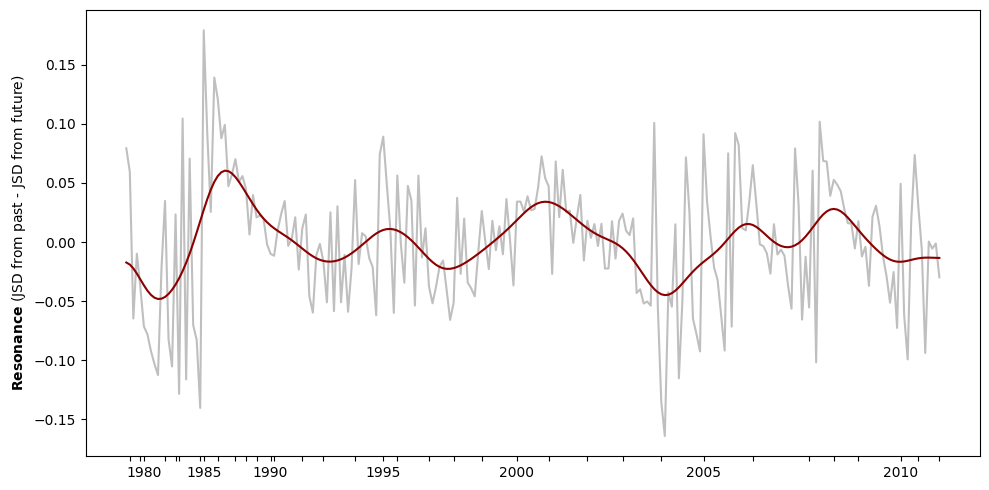

In [60]:
r_df = signal_df.iloc[20:-20, :]
r_hat = r_df['R_hat'].tolist()

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(r_hat, c='grey', alpha=0.5)
ax.plot(
    gaussian_filter1d(r_hat, sigma=5), c='darkred'
)

xticks_idx_n, xticks_label_n = generate_xticks(r_df.reset_index())
modified_ticks = ['' if i % 5 != 0 and i != xticks_label_n[0] else i for i in xticks_label_n]

values_to_hide = [1978, 1979]
modified_ticks = ['' if i in values_to_hide else i for i in modified_ticks]

ax.set_xticks(ticks=xticks_idx_n, labels=modified_ticks)
ax.set_ylabel(r'$\bf{Resonance}$ (JSD from past - JSD from future)')

plt.tight_layout()
plt.savefig('fig/resonance_w20_doc2doc.png', dpi=300)

In [89]:
smooth_r_hat = pd.Series(gaussian_filter1d(r_hat, sigma=5))
crosses_zero = (smooth_r_hat.shift(1) * smooth_r_hat) < 0


# add the window length to the beginning and end of the series
falses_len_window = pd.Series([False] * 20)
full_sig_crosses_zero = pd.concat([falses_len_window, crosses_zero, falses_len_window])
full_sig_crosses_zero = full_sig_crosses_zero.reset_index(drop=True)

# add a local max point (last resonance point to create a new segment for the last w docs)
full_sig_crosses_zero.iloc[-20] = True

# get dates where zero crossing occurs
signal_df['smooth_r_hat_crossing_zero'] = full_sig_crosses_zero
dates_crossing_zero = signal_df.query('smooth_r_hat_crossing_zero == True')['date'].tolist()
dates_crossing_zero = [stamp.strftime('%Y-%m-%d') for stamp in dates_crossing_zero]

# indices crossing zero
idx_crossing_zero = signal_df.query('smooth_r_hat_crossing_zero == True').index.tolist()
idx_crossing_zero_cutoff_adjusted = [idx - 20 for idx in idx_crossing_zero]

# change points df
change_point_df = pd.DataFrame({
    'date': dates_crossing_zero,
    'index_signal_df': idx_crossing_zero,
    'index_r_hat': idx_crossing_zero_cutoff_adjusted,
})

# manually drop change points that are too close to each other
illegal_dates = [
    "1994-07-01",
    "1996-06-01",
    "2006-04-01",
    "2006-07-01"
]

change_point_df_curated = change_point_df.query("date != @illegal_dates")
change_point_df_curated

,date,index_signal_df,index_r_hat
0,1983-10-01,40,20
1,1991-10-01,68,48
4,1999-05-01,125,105
5,2002-06-01,159,139
6,2005-10-01,191,171
9,2009-06-01,232,212
10,2012-08-01,252,232


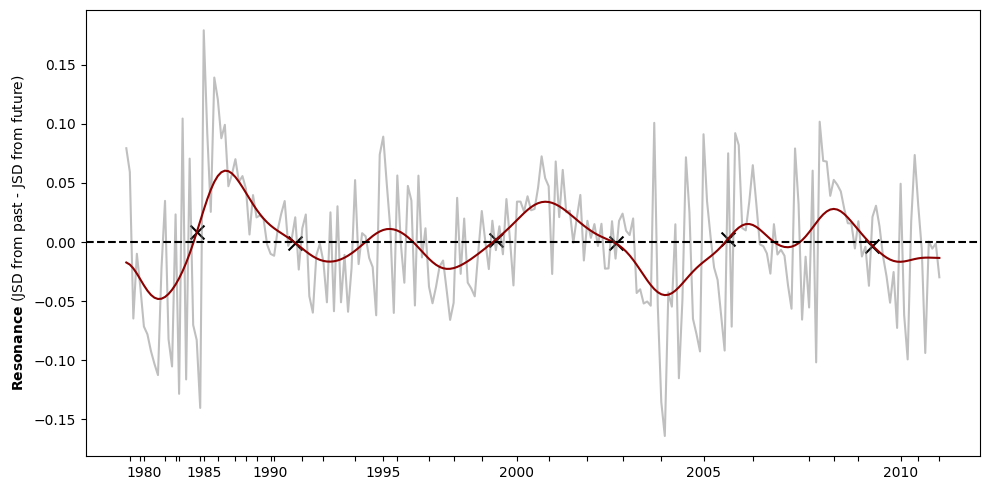

In [90]:
r_df = signal_df.iloc[20:-20, :]
r_hat = r_df['R_hat'].tolist()

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(r_hat, c='grey', alpha=0.5)
ax.plot(
    smooth_r_hat, c='darkred'
)

xticks_idx_n, xticks_label_n = generate_xticks(r_df.reset_index())
modified_ticks = ['' if i % 5 != 0 and i != xticks_label_n[0] else i for i in xticks_label_n]

values_to_hide = [1978, 1979]
modified_ticks = ['' if i in values_to_hide else i for i in modified_ticks]

ax.set_xticks(ticks=xticks_idx_n, labels=modified_ticks)
ax.set_ylabel(r'$\bf{Resonance}$ (JSD from past - JSD from future)')

# hline
ax.axhline(y=0.0, color='black', linestyle='--')

# flag indices that cross zero
indices = [idx for idx in change_point_df_curated['index_r_hat'].tolist() if idx >= 0 and idx < len(smooth_r_hat)]
points_to_plot = [smooth_r_hat[idx] for idx in indices]
plt.scatter(indices, points_to_plot, c='black', marker='x', s=100)

plt.tight_layout()
plt.savefig('fig/resonance_w20_zero_crosses.png', dpi=300)

In [91]:
change_point_df_curated['date'].tolist()

['1983-10-01',
 '1991-10-01',
 '1999-05-01',
 '2002-06-01',
 '2005-10-01',
 '2009-06-01',
 '2012-08-01']

## change detection

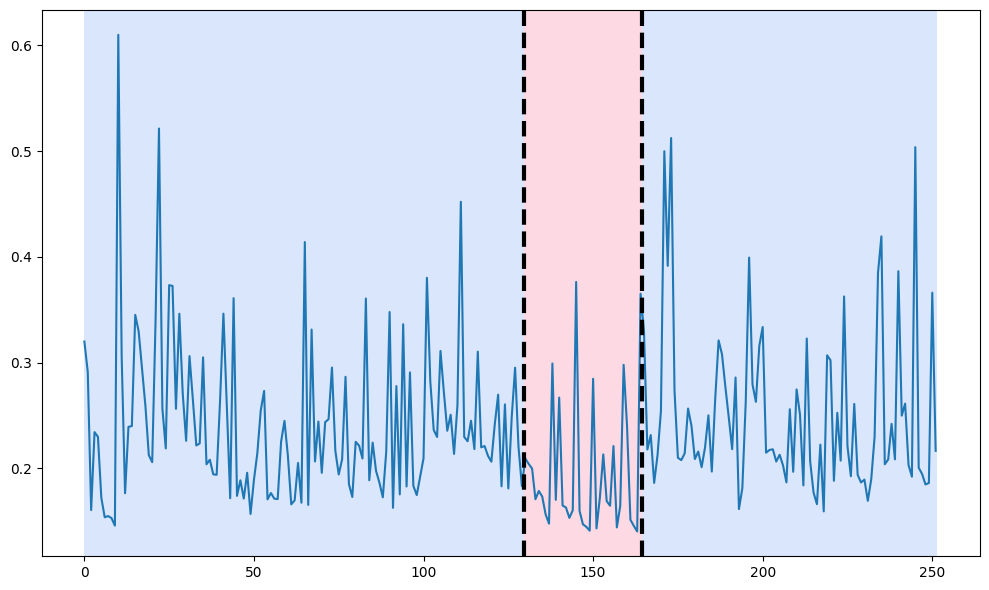

In [35]:
n_hat_np = np.array(n_hat) #.reshape(-1, 1)

# algo = ruptures.Pelt(model='l2', min_size=3, jump=5).fit(n_hat_np)
algo = ruptures.Pelt(model='l1').fit(n_hat_np)
result = algo.predict(pen=0.3)
fig, ax_arr = ruptures.display(
    n_hat_np, true_chg_pts=result, computed_chg_pts=result, figsize=(10, 6)
)